# CMIP5Figures.ipynb

Plot mean climate signal maps from downscaled CMIP5 datasets.

In [7]:

import xarray as xr
from analysisFuncs import plot_map
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import xesmf as xe
from glob import glob

mask = xr.open_dataset('conus_gmet_mask.nc')['mask'].sel(lat=slice(25.,50.),lon=slice(-125.,-67.))
cmap2 = mpl.cm.BrBG

cmap = plt.get_cmap('coolwarm_r')
bounds = np.array([0, 0.5, 0.75, 0.9, 1, 1.5, 2, 3, 4, 5, 6])


def increase_cb_labels(cb,labelsize=14):

    cb.ax.xaxis.set_tick_params(labelsize=labelsize)  # Set tick label font size
    for tick in cb.ax.get_xticklabels():       # Loop through tick labels
        tick.set_fontweight('bold')            # Set each tick label to bold


## -----------------------------------------------------------------
# Function to find annual climate metric, func, from a dataset, ds

def applyFunc(ds,func,thr=0.,time_var='time',months='ALL'):
    
    if time_var!='time':
        ds = ds.rename({time_var:'time'})

    if months!='ALL':
        # Subset data from specified months, where months is in format of [6,7,8] for JJA, for example
        ds = ds.sel(time=ds['time.month'].isin(months))
    
    if func == 'std': result = ds.std('time',skipna=True)
    
    elif func == 'sum': result = ds.sum('time',skipna=True)
    
    elif func == 'mean': result = ds.mean('time',skipna=True)
    
    elif func == 'max': result = ds.max('time', skipna=True)
    
    elif func == 'q95': result = ds.chunk(dict(time=-1)).quantile(0.95, 'time')
    
    elif func == 'q99': result = ds.chunk(dict(time=-1)).quantile(0.99, 'time')
        
    elif func == 'count': result = ds.where(ds>thr).count('time')

    elif func == '2yr': result = ds.groupby('time.year').max(skipna=True).median('year')

    elif func == '5yr': result = ds.groupby('time.year').max(skipna=True).chunk(dict(year=-1)).quantile(.8,'year')
    
    elif func == 'r95ptot':
        if thr==0.:
            print('No threshold given. Calculating from ds.')
            thr = ds.chunk(dict(time=-1)).groupby('time.year').quantile(0.95)
            years = thr.year.values
            if len(years)>30:
                thr = thr.sel(year=slice(years[0],years[30])).mean('year')
            else: thr = thr.mean('year')
        
        annualtot = ds.groupby('time.year').sum().values
        result = ds.where(ds>thr).sum('time')/annualtot
    
    elif func == 'r99ptot':
        if thr==0.:
            print('No threshold given. Calculating from ds.')
            thr = ds.chunk(dict(time=-1)).groupby('time.year').quantile(0.99)
            years = thr.year.values
            thr = thr.sel(year=slice(years[0],years[30])).mean('year')
        
        annualtot = ds.groupby('time.year').sum().values
        result = ds.where(ds>thr).groupby('time.year').sum()/annualtot
    
    elif func == 'trend':
        result = ds.polyfit(dim="year", deg=1,skipna=True).polyfit_coefficients.sel(degree=1)
    
    else:
        print('This climate metric is not recognized')
    
    return(result)


In [12]:

encoding = {var: {"zlib": True, "complevel": 4} for var in ds.data_vars}
ds.to_netcdf('stat_files/'+f,encoding = encoding)
file_size = os.path.getsize('stat_files/'+f)
file_size_gb = file_size / (1024 * 1024)
print(f"File size: {file_size_gb:.2f} MB")

File size: 8.78 MB


In [13]:
import os
files = np.sort(os.listdir('stat_files/'))

for f in files[2:]:
    print(f)
    
    file_size = os.path.getsize('stat_files/'+f)
    file_size_gb = file_size / (1024 * 1024)
    print(f"File size: {file_size_gb:.2f} MB")
    ds = xr.open_dataset('stat_files/'+f).copy()
    os.remove('stat_files/'+f)
    encoding = {var: {"zlib": True, "complevel": 4} for var in ds.data_vars}
    ds.to_netcdf('stat_files/'+f,encoding = encoding)
    file_size = os.path.getsize('stat_files/'+f)
    file_size_gb = file_size / (1024 * 1024)
    print(f"File size: {file_size_gb:.2f} MB")

BCCA_CMIP5_signal_tasmax.nc
File size: 9.40 MB
File size: 4.16 MB
BCCA_CMIP5_signal_tasmin.nc
File size: 14.10 MB
File size: 6.89 MB
BCSD_CMIP5_signal_pr.nc
File size: 24.67 MB
File size: 1.44 MB
BCSD_CMIP5_signal_tasmax.nc
File size: 10.97 MB
File size: 3.06 MB
BCSD_CMIP5_signal_tasmin.nc
File size: 14.10 MB
File size: 0.79 MB
DEEPSD_CMIP6_pr_1970_2010.nc
File size: 0.93 MB
File size: 0.57 MB
DEEPSD_CMIP6_ssp370_signal_pr.nc
File size: 4.26 MB
File size: 2.01 MB
DEEPSD_CMIP6_ssp370_signal_tasmax.nc
File size: 2.85 MB
File size: 1.12 MB
DEEPSD_CMIP6_ssp585_signal_pr.nc
File size: 2.14 MB
File size: 1.02 MB
DEEPSD_CMIP6_ssp585_signal_tasmax.nc
File size: 2.85 MB
File size: 1.13 MB
DEEPSD_CMIP6_tasmax_1970_2010.nc
File size: 0.93 MB
File size: 0.61 MB
DEEPSD_CMIP6_tasmin_1970_2010.nc
File size: 0.93 MB
File size: 0.61 MB
GARDLENS_CMIP6_pr_1970_2010.nc
File size: 0.34 MB
File size: 0.34 MB
GARDLENS_CMIP6_ssp370_signal_pr.nc
File size: 2.14 MB
File size: 1.28 MB
GARDLENS_CMIP6_ssp370_signa

### Code to write GMET signals to a new file - only need to do this once

In [3]:

## Read in GMET for this region
files = glob('/glade/campaign/ral/hap/anewman/conus_v1p2/eighth/v2_landmask/conus_daily_eighth_*1231_001.nc4')
ds = xr.open_mfdataset(np.sort(files)).sel(time=slice('1980','2000'))
ds['tasmin'] = ds['t_mean']-0.5*ds['t_range'].values
ds['tasmax'] = ds['t_mean']+0.5*ds['t_range'].values
ds = ds.drop(('t_mean','t_range')).rename({'pcp':'pr'})
# Calculate climate statistics for this historical period so that we can normalize downscaled signal by climatological value
gmet_stats = ds.mean('time')
for var in ('pr','tasmin','tasmax'):
    if var=='pr':
        stats=('mean_jja','sum','q95','std','2yr','5yr')
    elif var=='tasmin':
        stats = ('mean_djf','q95')
    elif var=='tasmax':
        stats = ('mean_jja','q95')
    gmet_stats = gmet_stats.rename({var:'mean_%s'%var})
    
    for stat in stats:
        if stat[-3:]=='jja':
            gmet_stats['%s_%s'%(stat,var)] = applyFunc(ds[var],stat[:-4],months=[6,7,8])
        elif stat[-3:]=='djf':
            gmet_stats['%s_%s'%(stat,var)] = applyFunc(ds[var],stat[:-4],months=[1,2,12])
        else:
            gmet_stats['%s_%s'%(stat,var)] = applyFunc(ds[var],stat)

gmet_stats = gmet_stats.drop('quantile').load()

# Regrid to common 1/8 grid
extent = (25.,50.,-67.,-125.)
ds_out = xe.util.grid_2d(extent[3], extent[2], 1./8, extent[1], extent[0], -1./8)
regridder = xe.Regridder(gmet_stats.rename({'lat':'latitude','lon':'longitude'}), ds_out, 'conservative')
gmet_stats = regridder(gmet_stats)
gmet_stats = gmet_stats.assign(y=gmet_stats.lat[:,0].values).assign(x=gmet_stats.lon[0,:].values).drop_vars(('lat','lon')).rename({'y':'lat','x':'lon'})
gmet_stats.to_netcdf('GMET_stats_regridded.nc')


/glade/work/shartke/conda-envs/samEnv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/glade/work/shartke/conda-envs/samEnv/lib/python3.7/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/glade/work/shartke/conda-envs/samEnv/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/shartke/conda-envs/samEnv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/glade/work/shartke/conda-envs/samEnv/lib/python3.7/site-packages/xesmf/frontend.py:599: UserWarning: Using dimensions ('lat', 'lon') from data variable elevation as the horizontal dimensions for the regridding.
  UserWarning,


### Code to read in precipitation and maximum temperature signals for all downscaled datasets

In [3]:

gmet_stat = xr.open_dataset('GMET_stats_regridded.nc')
cmip = 'CMIP5'
var = 'pr'

if cmip=='CMIP5':
    datasets = ('BCSD','LOCA','BCCA','MACA','ICAR','GARD','NEXGDDP','NACORDEX')
    scen = ''
elif cmip=='CMIP6':
    datasets = ('DEEPSD','LOCA2','NEXGDDP','UCLAWRF')
    scen = '_ssp370'

files = []

for dataset in datasets[:]:
    
    ds = xr.open_dataset('stat_files/%s_%s%s_signal_%s.nc'%(dataset,cmip,scen,var))
    ds['dset'] = dataset
    try: ds = ds.rename({'latitude':'lat','longitude':'lon'})
    except: i=0
    try: ds = ds.drop('5yr_pr').drop('2yr_pr')
    except: i=0
    if var=='tasmin': ds = ds[['mean_tasmin','q95_tasmin','dset']]   
    #print(ds)    
    files.append(ds.sortby('lat').sel(lat=slice(25.,50.),lon=slice(-125.,-67.)))

ds = xr.concat(files,dim='dset',coords='minimal')
if cmip=='CMIP5': ds = ds.sel(gcm=['CanESM2','GFDL-CM3','MIROC5','MRI-CGCM3','NorESM1-M'])
elif cmip=='CMIP6': ds = ds.sel(gcm=['CanESM5','EC-Earth3','MIROC6','MRI-ESM2-0','NorESM2-MM'])
print(ds)


<xarray.Dataset>
Dimensions:      (lat: 200, lon: 464, gcm: 5, dset: 8)
Coordinates:
  * lat          (lat) float64 25.06 25.19 25.31 25.44 ... 49.69 49.81 49.94
  * lon          (lon) float64 -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * gcm          (gcm) object 'CanESM2' 'GFDL-CM3' ... 'MRI-CGCM3' 'NorESM1-M'
  * dset         (dset) <U8 'BCSD' 'LOCA' 'BCCA' ... 'GARD' 'NEXGDDP' 'NACORDEX'
Data variables:
    mean_pr      (dset, gcm, lat, lon) float64 nan nan nan nan ... nan nan nan
    mean_jja_pr  (dset, gcm, lat, lon) float64 nan nan nan nan ... nan nan nan
    sum_pr       (dset, gcm, lat, lon) float64 nan nan nan nan ... nan nan nan
    q95_pr       (dset, gcm, lat, lon) float64 nan nan nan nan ... nan nan nan
    std_pr       (dset, gcm, lat, lon) float32 nan nan nan nan ... nan nan nan



## Plotting Code for Figures 2 and 3, Supplmental Figures 1-4

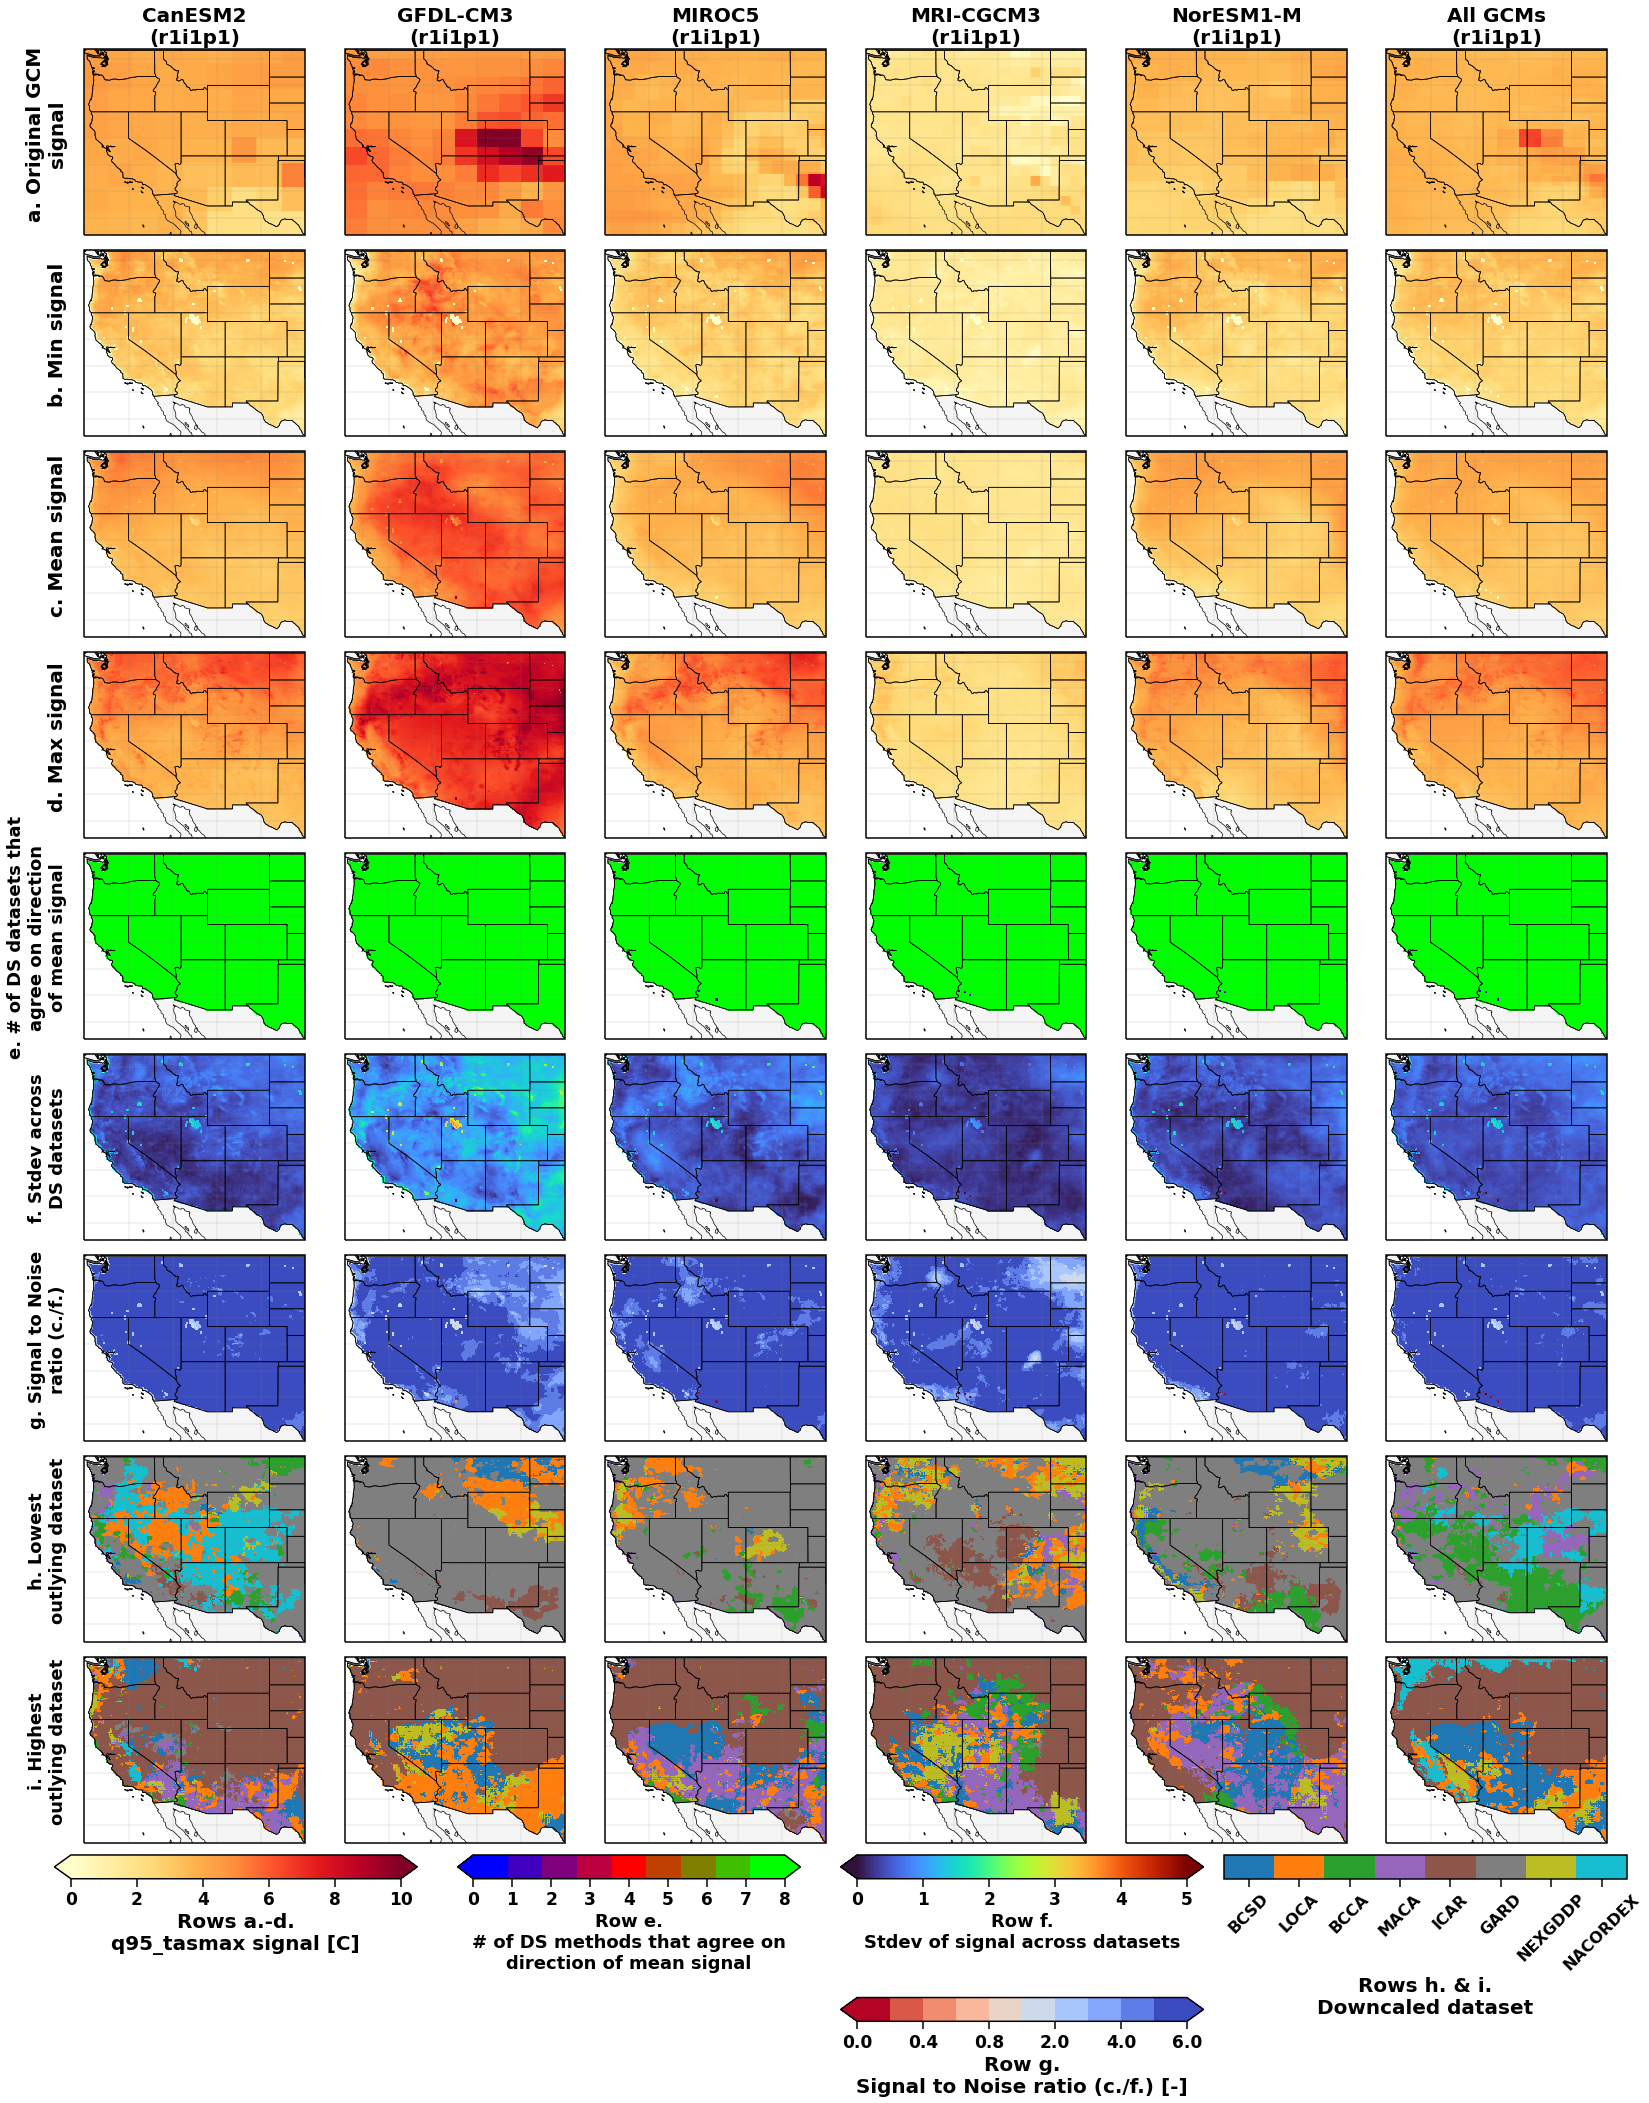

In [36]:

gcm_ds = xr.open_dataset('stat_files/GCM_%s_rcp45_signal_%s.nc'%(cmip,var))

# Function to map S/N ratio values to bins in colormap to make boundary around 1 more visible
def map_values(ds):
    
    bins = np.array([0., 0.2, 0.4, 0.6, 0.8, 1., 2., 3., 4., 5., 6.]) # Define the bins and the corresponding new values
    new_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    binned_data = np.digitize(ds.values, bins) # Digitize the data to map it to the bin indices
    new_ds = ds.copy()
    new_ds.values = binned_data
    
    return(new_ds)


def plot_agreement(ds,xlim,ylim,stat,cmap,save_plot=True,option=''):

    
    ngcms = len(ds.gcm.values)+1
    ndsets = len(ds.dset.values)
    if option=='': fig = plt.figure(figsize=(int(ngcms*4.8),int(ylim[1]-ylim[0])+12)); ncol=9
    else: fig = plt.figure(figsize=(int(ngcms*4.8),int(ylim[1]-ylim[0])+8)); ncol=7
    proj = ccrs.PlateCarree()
    
    tabcmap = plt.cm.get_cmap('tab10', ndsets)  # Get tab10 colormap
    cmap2 = plt.cm.get_cmap('brg', ndsets+1)  # Get tab10 colormap
    
    if (stat=='mean_pr') or (stat=='mean_jja_pr'):
        vmin=-2.; vmax=2.; diffmax = 10
    elif stat=='max_pr':
        vmin=-40.; vmax=40.; diffmax = 30.
    elif stat=='q95_pr':
        vmin=-10.; vmax=10.; diffmax = 10.
    elif stat=='std_pr':
        vmin=-3.; vmax=3.; diffmax = 10.
    elif stat=='2yr_pr':
        vmin=-40.; vmax=40.; diffmax = 25.
    elif stat=='sum_pr':
        vmin=-400.; vmax=400.; diffmax = 25.
    elif stat=='mean_jja_pr':
        vmin=-10.; vmax=10.; diffmax = 3.
    elif (stat=='mean_tasmax') or (stat=='mean_jja_tasmax') or (stat=='mean_djf_tasmin') or (stat=='mean_tasmin'):
        vmin=0.; vmax=10.; diffmax = 3.
    elif (stat=='q95_tasmin') or (stat=='q95_tasmax'):
        vmin=0.; vmax=10.; diffmax = 5.
    
    # ysize = ds.sizes['lat']
    # xsize = ds.sizes['lon']

    cmap = plt.get_cmap('coolwarm')
    bounds = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 6])
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N, clip=False)
    
    i = 1
    for g in np.concatenate((ds.gcm.values,['All GCMs'])):

        if g=='All GCMs':
            ds2 = ds.mean('gcm')
            ds3 = gcm_ds.mean('gcm')
        else:
            ds2 = ds.sel(gcm=g)
            ds3 = gcm_ds.sel(gcm=g)

        # -- Plot original signal for each GCM
        ax1 = fig.add_subplot(ncol,ngcms,i,projection=proj)
        if stat[-2:]=='pr': ds3[stat]=ds3[stat]*86400# convert from kg/m2s to mm/d
        plot_map(ds3[stat],ax=ax1,cmap=var_cmap,ylim=ylim,xlim=xlim,vmin=vmin,vmax=vmax,
                 colorbar=False,bottom=False,left=False)
        if i==1:
            ax1.text(-0.08, 0.55, 'a. Original GCM\nsignal', va='bottom', ha='center',rotation='vertical',
                 fontsize=20,rotation_mode='anchor',transform=ax1.transAxes,fontweight='bold')
        ax1.set_title(g+'\n(r1i1p1)',fontsize=20,fontweight='bold')
        
        # -- Plot mean signal for each GCM
        ax1 = fig.add_subplot(ncol,ngcms,ngcms+i,projection=proj)
        gcm_min = ds2.min('dset',skipna=True)[stat]
        plot_map(gcm_min.where(mask.values),ax=ax1,cmap=var_cmap,ylim=ylim,xlim=xlim,vmin=vmin,vmax=vmax,
                 colorbar=False,bottom=False,left=False)
        if i==1:
            ax1.text(-0.08, 0.55, 'b. Min signal', va='bottom', ha='center',rotation='vertical',
                 fontsize=20,rotation_mode='anchor',transform=ax1.transAxes,fontweight='bold')
        ax1.set_title('')
        
        # -- Plot mean signal for each GCM
        ax1 = fig.add_subplot(ncol,ngcms,2*ngcms+i,projection=proj)
        gcm_mean = ds2.mean('dset',skipna=True)[stat]
        plot_map(gcm_mean.where(mask.values),ax=ax1,cmap=var_cmap,ylim=ylim,xlim=xlim,vmin=vmin,vmax=vmax,
                 colorbar=False,left=False,bottom=False)
        if i==1:
            ax1.text(-0.08, 0.55, 'c. Mean signal', va='bottom', ha='center',rotation='vertical',
                 fontsize=20,rotation_mode='anchor',transform=ax1.transAxes,fontweight='bold')
        ax1.set_title('')

        # -- Plot mean signal for each GCM
        ax1 = fig.add_subplot(ncol,ngcms,3*ngcms+i,projection=proj)
        gcm_max = ds2.max('dset',skipna=True)[stat]
        plot_map(gcm_max.where(mask.values),ax=ax1,cmap=var_cmap,ylim=ylim,xlim=xlim,vmin=vmin,vmax=vmax,
                 colorbar=False,left=False,bottom=False)
        if i==1:
            ax1.text(-0.08, 0.55, 'd. Max signal', va='bottom', ha='center',rotation='vertical',
                 fontsize=20,rotation_mode='anchor',transform=ax1.transAxes,fontweight='bold')
        ax1.set_title('')

        if option=='':
            # -- Plot percentage of downscaled datasets that agree on direction of mean signal
            ax1 = fig.add_subplot(ncol,ngcms,4*ngcms+i,projection=proj)
            ds_sign = ds2[stat].where(ds2[stat]<0.0, 1)#.sel(gcm=g)
            ds_sign = ds_sign.where(ds_sign>0.0, -1) # this is the direction of the signal estimated by all downscaled datasets
            mean_sign = gcm_mean.where(gcm_mean<0.0, 1)
            mean_sign = mean_sign.where(mean_sign>0.0, -1) # this is the direction of the mean signal averaged across downscaled datasets
            # n_agreement = 100*ds_sign.where(ds_sign==mean_sign,drop=True).count('dset')/ndsets
            n_agreement = ds_sign.where(ds_sign==mean_sign,drop=True).count('dset')
            plot_map(n_agreement.where(mask.values),ax=ax1,cmap=cmap2,ylim=ylim,xlim=xlim,vmin=0.,vmax=7.,
                     colorbar=False,left=False,bottom=False)
            if i==1:
                ax1.text(-0.08, 0.55, 'e. # of DS datasets that\nagree on direction\nof mean signal', va='bottom', ha='center',rotation='vertical',
                     fontsize=18,rotation_mode='anchor',transform=ax1.transAxes,fontweight='bold')
            ax1.set_title('')
            
            # -- Plot stdev across downscaled datasets normalized by mean gcm signal
            ax1 = fig.add_subplot(ncol,ngcms,5*ngcms+i,projection=proj)
            if stat[-2:]=='pr':
                gcm_std = 100*ds2.std('dset',skipna=True)[stat]/gmet_stat[stat]
                diffmax = 25.
            else:
                gcm_std = ds2.std('dset',skipna=True)[stat]
            # plot_map(gcm_std.where(abs(gcm_mean)>0.4)/abs(gcm_mean).where(abs(gcm_mean)>0.4),ax=ax1,cmap='turbo',
            #          ylim=ylim,xlim=xlim,vmin=0.,vmax=diffmax,
            #          colorbar=False,left=False,bottom=False)
            plot_map(gcm_std.where(mask.values),ax=ax1,cmap='turbo',ylim=ylim,xlim=xlim,vmin=0.,vmax=diffmax,
                     colorbar=False,left=False,bottom=False)
            if i==1:
                ax1.text(-0.08, 0.5, 'f. Stdev across\nDS datasets', va='bottom', ha='center',rotation='vertical',
                     fontsize=18,rotation_mode='anchor',transform=ax1.transAxes,fontweight='bold')
            ax1.set_title('')

        # -- Plot S/N ratio
        ax1 = fig.add_subplot(ncol,ngcms,(ncol-3)*ngcms+i,projection=proj)
        snr = gcm_mean/ds2.std('dset',skipna=True)[stat]
        snr = map_values(snr)
        plot_map(snr.where(mask.values),ax=ax1,cmap='coolwarm_r',
                 vmin=1.,vmax=10.,ylim=ylim,xlim=xlim,colorbar=False,left=False,bottom=False)
        
        mask0 = (gcm_max.where(mask.values) > 0) & (gcm_min.where(mask.values) < 0)
        ax1.contourf(snr.lon, snr.lat, mask0, levels=[0.5, 1], colors='none', hatches=['///'], transform=ccrs.PlateCarree()) # Add hatching where the condition is True

        if i==1:
            if option=='short': letter='e'
            else: letter='g'
            if (var=='pr') or (option=='short'): text = '%s. Signal to Noise\nratio (c./Stdev)'%letter
            else: text = '%s. Signal to Noise\nratio (c./f.)'%letter
            ax1.text(-0.08, 0.55, text, va='bottom', ha='center',rotation='vertical',
                 fontsize=18,rotation_mode='anchor',transform=ax1.transAxes,fontweight='bold')
        ax1.set_title('')
        
        # -- Plot the downscaled dataset that lies farthest from the mean GCM signal on the low end
        ax1 = fig.add_subplot(ncol,ngcms,(ncol-2)*ngcms+i,projection=proj)
        gcm_diff = ds2[stat] - ds2.mean('dset',skipna=True)[stat]
        argmax_gcm = gcm_diff.argmin(dim='dset',skipna=True)
        argmax_gcm[99,100] = 0; argmax_gcm[100,100] = ndsets-1
            
        plot_map(argmax_gcm.where(mask.values),ax=ax1,cmap=tabcmap,colorbar=False,
                 ylim=ylim,xlim=xlim,left=False,bottom=False)
        if i==1:
            if option=='short': letter='f'
            else: letter='h'
            ax1.text(-0.08, 0.55, '%s. Lowest\noutlying dataset'%letter, va='bottom', ha='center',rotation='vertical',
                 fontsize=18,rotation_mode='anchor',transform=ax1.transAxes,fontweight='bold')
        ax1.set_title('')

        # -- Plot the downscaled dataset that lies farthest from the mean GCM signal on the high end
        ax1 = fig.add_subplot(ncol,ngcms,(ncol-1)*ngcms+i,projection=proj)
        argmax_gcm = gcm_diff.argmax(dim='dset',skipna=True)
        argmax_gcm[99,100] = 0;argmax_gcm[100,100] = ndsets-1
            
        plot_map(argmax_gcm.where(mask.values),ax=ax1,cmap=tabcmap,colorbar=False,
                 ylim=ylim,xlim=xlim,left=False,bottom=False)
        if i==1:
            if option=='short': letter='g'
            else: letter='i'
            ax1.text(-0.08, 0.55, '%s. Highest\noutlying dataset'%letter, va='bottom', ha='center',rotation='vertical',
                 fontsize=18,rotation_mode='anchor',transform=ax1.transAxes,fontweight='bold')
        ax1.set_title('')
    
        i+=1

    
    units = 'mm/d' if var=='pr' else 'C'
    if option=='': ax2 = fig.add_axes([0.12, 0.11, 0.18, 0.01])
    else: ax2 = fig.add_axes([0.14, 0.11, 0.2, 0.01])
    cb = mpl.colorbar.ColorbarBase(ax2, orientation='horizontal', cmap=var_cmap,
                                   norm=mpl.colors.Normalize(vmin, vmax),extend='both')
    cb.set_label('Rows a.-d.\n%s signal [%s]'%(stat,units), fontsize=20,fontweight='bold')
    increase_cb_labels(cb,17)

    if option=='':
        ax2 = fig.add_axes([0.32, 0.11, 0.17, 0.01])
        cb = mpl.colorbar.ColorbarBase(ax2, orientation='horizontal', cmap=cmap2,
                                       norm=mpl.colors.Normalize(0., 8.),extend='both')
        cb.set_label('Row e.\n# of DS methods that agree on\ndirection of mean signal', fontsize=18)
        cb.ax.set_xticks(np.arange(0,9))
        cb.ax.set_xticklabels(np.arange(0,9))
        increase_cb_labels(cb,17)
        
        ax2 = fig.add_axes([0.51, 0.11, 0.18, 0.01])
        cb = mpl.colorbar.ColorbarBase(ax2, orientation='horizontal', cmap='turbo',
                                       norm=mpl.colors.Normalize(0., diffmax),extend='both')
        if stat[-2:]=='pr': cb.set_label('Row e.\nStdev of signal across datasets\n[% of historical value]', fontsize=17)
        else: cb.set_label('Row f.\nStdev of signal across datasets', fontsize=18)
        increase_cb_labels(cb,17)

        letters = ['g.','h. & i.']
        ax2 = fig.add_axes([0.51, 0.05, 0.18, 0.01])
    else:
        letters = ['e.','f. & g.']
        ax2 = fig.add_axes([0.41, 0.11, 0.2, 0.01])

    cb = mpl.colorbar.ColorbarBase(ax2, orientation='horizontal', cmap='coolwarm_r',
                                   norm=norm,extend='both')
    if (stat[-2:]=='pr') or (option=='short'): cb.set_label('Row %s.\nSignal to Noise ratio (c./Stdev) [-]'%letters[0], fontsize=20)
    else:  cb.set_label('Row %s\nSignal to Noise ratio (c./f.) [-]'%letters[0], fontsize=20)
    increase_cb_labels(cb,17)
    
    
    if option=='': ax2 = fig.add_axes([0.7, 0.11, 0.2, 0.01])
    else: ax2 = fig.add_axes([0.65, 0.11, 0.24, 0.01])
    tabnorm = mcolors.Normalize(vmin=0, vmax=ndsets)  # Normalize colormap
    cb = mpl.colorbar.ColorbarBase(ax2, orientation='horizontal', 
                                   cmap=tabcmap,norm=tabnorm,ticks=np.arange(ndsets),
                                   label='Downcaled dataset')
    cb.set_label('Rows %s\nDowncaled dataset'%letters[1], fontsize=20)
    cb.ax.set_xticks(np.arange(.5,ndsets,1.))
    cb.ax.set_xticklabels(list(ds.dset.values[i] for i in range(ndsets)), fontsize=16,rotation=45)
    increase_cb_labels(cb,16)
    plt.subplots_adjust(wspace=0.0,hspace=0.08)
    
    if save_plot==True:
        plt.savefig('figures/WCONUS_%s_%s_signal_agreement%s.jpg'%(cmip,stat,option),dpi=1200,bbox_inches='tight')
    plt.show()



conus = ((25.,50.),(-125.,-67.))
wash = ((44.7,49.5),(-125.,-116.9))
wconus = ((28.,49.1),(-125.,-100.))
if var=='pr': var_cmap = cmap2
else: var_cmap = 'YlOrRd'
plot_agreement(ds,ylim = wconus[0],xlim = wconus[1],stat = 'q95_tasmax', cmap=var_cmap, save_plot=True, option='')



## Example comparison of MIROC5 downscaled datasets for Figure 1

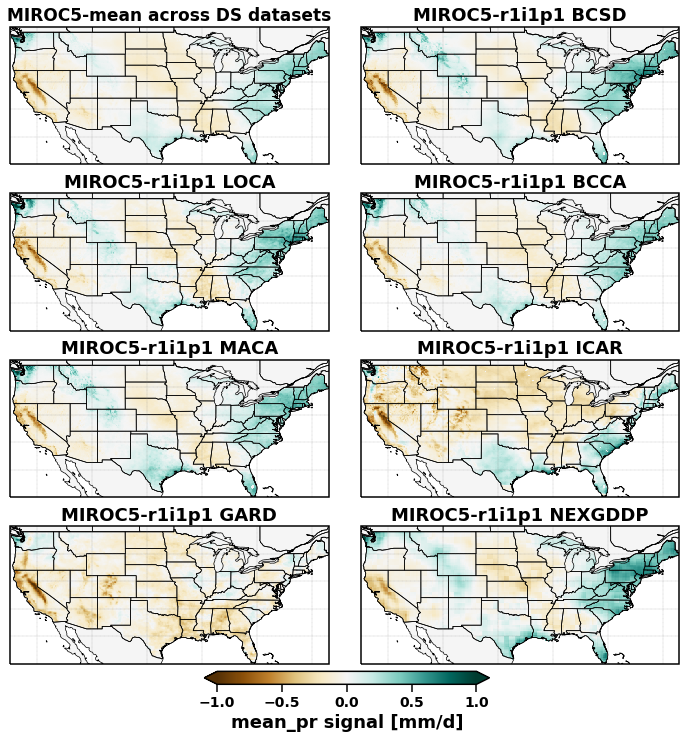

In [6]:
fig = plt.figure(figsize=(12,12))
proj = ccrs.PlateCarree()

ylim = (25.,50.); xlim = (-125.,-67.)

g = 'MIROC5'
stat = 'mean_pr'
vmin = -1.; vmax = 1.
#vmin=-5.;vmax=5.

ax1 = fig.add_subplot(4,2,1,projection=proj)
gcm_mean = ds.sel(gcm=g).mean('dset',skipna=True)[stat]
plot_map(gcm_mean.where(mask.values),ax=ax1,cmap=cmap2,ylim=ylim,xlim=xlim,vmin=vmin,vmax=vmax,
             colorbar=False,left=False,bottom=False)
ax1.set_title('MIROC5-mean across DS datasets',fontsize=17)

i = 2
for d in ds.dset.values[:7]:

    ax1 = fig.add_subplot(4,2,i,projection=proj)
    
    plot_map(ds.sel(gcm=g,dset=d)[stat].where(mask.values),ax=ax1,cmap=cmap2,ylim=ylim,xlim=xlim,vmin=vmin,vmax=vmax,
             colorbar=False,left=False,bottom=False)
    ax1.set_title(g+'-r1i1p1 %s'%d,fontsize=18)
    i+=1

ax2 = fig.add_axes([0.35, 0.11, 0.33, 0.015])
cb = mpl.colorbar.ColorbarBase(ax2, orientation='horizontal', 
                               cmap=cmap2,
                               norm=mpl.colors.Normalize(vmin,vmax),  # vmax and vmin
                               extend='both')
increase_cb_labels(cb)
cb.set_label(label='%s signal [mm/d]'%stat,fontsize=18,weight='bold')

plt.subplots_adjust(hspace=0.09,wspace=0.1)
plt.show()
